In [1]:
from pathlib import Path
import pyrootutils
import os

notebook_path = Path(os.path.abspath(""))
pyrootutils.setup_root(notebook_path, indicator=".project-root", pythonpath=True)

DIRNAME = r"/cluster/home/vjimenez/adv_pa_new/results/artificial"

In [2]:
import torch
from torch.utils.data import TensorDataset

from pametric.datautils import MultienvDataset, LogitsDataset
from src.data.components.collate_functions import MultiEnv_collate_fn
from pametric.metrics import PosteriorAgreementBase

def test_artificial(
        prob: float,
        beta0: float,
        pa_epochs: int,
        optimizer_lr: float,
        optimizer_name: str,
        logit_diff: float = 1.0
    ) -> None:
    """
    Provide metrics (including PA) of a constant, random and perfect classifier.
    """
    torch.manual_seed(0)
    
    def _generate_logits(y: torch.Tensor) -> torch.Tensor:
        sample_size = y.size(0)
        logits = -(logit_diff/2.0)*torch.ones((sample_size, 2), dtype=torch.float)
        logits[torch.arange(sample_size), y] = logit_diff/2.0
        return logits

    sample_size = 100
    y = torch.bernoulli(torch.ones(sample_size), prob).to(dtype=torch.long)

    def _generate_preds(y: torch.Tensor, classifier_type: str) -> torch.Tensor:
        assert classifier_type in ["perfect", "random", "constant"]

        if classifier_type == "perfect":
            return y
        elif classifier_type == "random":
            return y[torch.randperm(y.size(0))]
        else: # constant
            return torch.zeros_like(y)
        
    def _accuracy(y: torch.Tensor, preds: torch.tensor) -> float:
        return (y == preds).float().mean().item()

    for classifier_type in ["random"]: #, "random", "constant"]:
        preds_dom1 = _generate_preds(y, classifier_type)
        logits_dom1 = _generate_logits(preds_dom1)

        preds_dom2 = _generate_preds(y, classifier_type)
        logits_dom2 = _generate_logits(preds_dom2)

        accuracy = _accuracy(torch.cat([y, y]), torch.cat([preds_dom1, preds_dom2]))
        # print(f"\nACC '{classifier_type}': {accuracy:.2f}".format(accuracy=accuracy))

        pa_metric = PosteriorAgreementBase(
                dataset = LogitsDataset([logits_dom1, logits_dom2], y),
                pa_epochs = pa_epochs,
                beta0 = beta0,
                pairing_strategy = None,
                optimizer_name = optimizer_name,
                optimizer_lr = optimizer_lr
        )

        pa_metric.update(classifier=torch.nn.Identity())
        metric_dict = pa_metric.compute()
        # print(f"logPA '{classifier_type}': {metric_dict['logPA']:.4f}".format(pa=metric_dict["logPA"]))
        # print(f"beta: {metric_dict['beta']}")
    return pa_metric.betas, pa_metric.logPAs, accuracy

/cluster/project/jbuhmann/posterior_agreement/.venvs/adv_pa/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import numpy as np

In [4]:
import matplotlib.colors as mcolors
from itertools import cycle

named_colors = list(mcolors.TABLEAU_COLORS)

In [5]:
def _call_artificial(pa_epochs: int, beta0: float, lr: float, opt: str, ldiff: float = 1.0):
    beta, logPA, acc = test_artificial(
                            prob=0.5,
                            beta0 = beta0,
                            pa_epochs = pa_epochs,
                            optimizer_lr = lr,
                            optimizer_name= opt,
                            logit_diff=ldiff
                        )

    results_dict = {
        "epochs": torch.arange(1, pa_epochs + 1),
        "beta0": [str(beta0)]*pa_epochs,
        "lr": [str(lr)]*pa_epochs,
        "ldiff": [str(ldiff)]*pa_epochs,
        "beta": beta,
        "logPA": logPA,
    }
    return results_dict

def get_artificial_results(pa_epochs_list: list, beta0_list: list, lr_list: list, opt_list: list, ldiff_list = None):
    ldiff_list = ldiff_list if ldiff_list != None else [1.0]*len(pa_epochs_list)

    df_list = []
    for pa_epochs, beta0, lr, opt, ldiff in zip(pa_epochs_list, beta0_list, lr_list, opt_list, ldiff_list):
        results_dict = _call_artificial(pa_epochs, beta0, lr, opt, ldiff)
        df_list.append(
            pd.DataFrame(results_dict)
        )        
    return pd.concat(df_list)

In [6]:
METRIC_DICT = {
    "beta": r"$\beta$",
    "logPA": "PA",
}

def plot_artificial(
        df: pd.DataFrame,
        metric: str,
        hue_attribute: str,
        hue_dict: dict,
        title: str,
        savedir: str,
        save: bool = False,
        yscale: bool = "symlog",
        legend: bool = True,
    ) -> None:
    """
    Plot of the different metrics for adversarial ratio.
    """

    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))
    
    # Create a line plot for PGD attack type with Seaborn
    _, ax = plt.subplots(figsize=(2 * 3.861, 2 * 2.7291))
    sns.set(font_scale=1.9)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = fontname
    sns.set_style("ticks")

    sns.lineplot(
        data=df,
        ax=ax,
        x="epochs",
        y=metric,
        hue=hue_attribute,
        style=hue_attribute,
        palette=hue_dict,
        dashes=False,
        marker="",
        linewidth=3,
        legend=legend
    )

    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_xticks([1] + [i for i in range(10, nepochs + 1, 10)]) # nepochs is global
    plt.xticks(rotation=45)

    ax.tick_params(axis="both", which="both", direction="in")
    xticks_font = fm.FontProperties(family=fontname)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(xticks_font)

    ax.grid(linestyle="--")
    ax.set_xlabel("Epochs", fontname=fontname)
    ax.set_ylabel(METRIC_DICT[metric], fontname=fontname)
    ax.set_yscale(yscale) 

    # ax.axhline(100*np.log(0.5), color="black", lw=3, ls="--", label=r"PA = N$\log \frac{1}{2}$")
    
    # Legend
    if legend == True:
        handles, labels = ax.get_legend_handles_labels()

        # FOR LR PLOTS:
        handles = [handles[-1]] + handles[:-1]#, handles[0]]
        labels = [labels[-1]] + [r"$\Delta$ = " + lab for lab in labels[:-1]]

        ax.legend(
            handles,
            labels,
            loc="best",
            handlelength=0.5,
            prop={
                "family": fontname,
                'size': 18
            }  
        )
    ax.set_title(title, fontname=fontname)
    plt.tight_layout()
    if save:
        plt.savefig(savedir)
        plt.clf()
        plt.close()
    else:
        plt.show()

In [276]:
global nepochs
nepochs = 100

In [277]:
# beta0_list = [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
ldiff_list = [0.5, 1.0, 2.0]
len_values = len(ldiff_list)

lr_list = [0.001]*len_values
opt_list = ["SGD"]*len_values
beta0_list = [1.0]*len_values

results_df = get_artificial_results([nepochs]*len_values, beta0_list, lr_list, opt_list, ldiff_list)

100%|██████████| 100/100 [00:02<00:00, 36.12it/s]


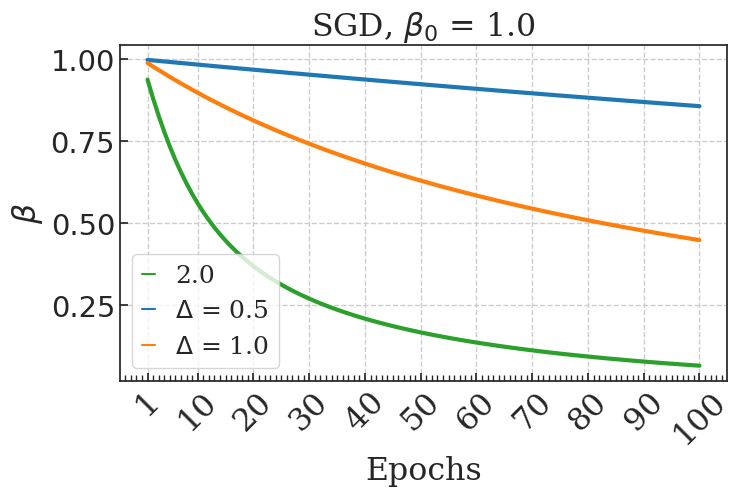

In [283]:
# Reinstantiate the cycle:
color_cycle = cycle(named_colors)
# color_cycle = cycle(["tab:blue"])

plot_artificial(
        df=results_df,
        metric="beta",
        hue_attribute="ldiff",
        hue_dict={
                str(val): next(color_cycle)
                for val in ldiff_list
        },
        title=r"SGD, $\beta_0$ = 1.0",
        savedir=os.path.join(DIRNAME, "nonrob_met=betas_hue=ldiff.png"),
        save = False,
        yscale = "linear",
        legend = False,
)

In [7]:
def plot_ldiff(
        df: pd.DataFrame,
        metric: str,
        hue_attribute: str,
        hue_dict: dict,
        title: str,
        savedir: str,
        save: bool = False,
        yscale: bool = "symlog",
        legend: bool = True,
    ) -> None:
    """
    Plot of the different metrics for adversarial ratio.
    """

    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))
    
    # Create a line plot for PGD attack type with Seaborn
    _, ax = plt.subplots(figsize=(2 * 3.861, 2 * 2.7291))
    sns.set(font_scale=1.9)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = fontname
    sns.set_style("ticks")

    sns.lineplot(
        data=df,
        ax=ax,
        x="epochs",
        y=metric,
        hue=hue_attribute,
        style=hue_attribute,
        palette=hue_dict,
        dashes=False,
        marker="",
        linewidth=3,
        legend=legend
    )

    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_xticks([1] + [i for i in range(10, nepochs + 1, 10)]) # nepochs is global
    plt.xticks(rotation=45)

    ax.tick_params(axis="both", which="both", direction="in")
    xticks_font = fm.FontProperties(family=fontname)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(xticks_font)

    ax.grid(linestyle="--")
    ax.set_xlabel("Epochs", fontname=fontname)
    ax.set_ylabel(METRIC_DICT[metric], fontname=fontname)
    ax.set_yscale(yscale) 

    # ax.axhline(0.0, color="black", lw=3, ls="--", label=r"$\beta = 0$")
    
    # Legend
    if legend == True:
        handles, labels = ax.get_legend_handles_labels()

        # FOR LR PLOTS:
        # handles = [handles[-1], handles[0]]
        # labels = [labels[-1], r"LR = 1e-2, 1e-3, 1e-4"]

        ax.legend(
            handles,
            labels,
            loc="best",
            handlelength=0.5,
            prop={
                "family": fontname,
                'size': 18
            }  
        )
    ax.set_title(title, fontname=fontname)
    plt.tight_layout()
    if save:
        plt.savefig(savedir)
        plt.clf()
        plt.close()
    else:
        plt.show()

# Artificial From Tables

In [36]:
import os
import pickle
import torch
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

CLASS_HUE_DICT = {
    "constant": "black",
    "random": "tab:orange",
    "perfect": "tab:blue"
}

DASHES_DICT = {
    "constant": (4,2),
    "random": "",
    "perfect": ""
}

TITLE_DICT = {
    "beta": r"$\beta$",
    "logPA": "PA",
    "acc": "Accuracy"
}

def load_df_artificial(moreepochs: bool = False):
    _moreepochs = ""
    if moreepochs == True:
        _moreepochs = "_moreepochs"

    # Loading the data
    file_path = f'/cluster/home/vjimenez/adv_pa_new/results/artificial/artificial_results{_moreepochs}.pkl'
    with open(file_path, 'rb') as f:
        loaded_results = pickle.load(f)

    # Access the data
    loaded_accs = loaded_results['accs']
    loaded_logPAs = loaded_results['logPAs']
    loaded_betas = loaded_results['betas']
    loaded_probs = loaded_results['probs']

    df_list = []
    classifier_types = ["perfect", "random", "constant"]
    for iclass, classtype in enumerate(classifier_types):
        data_dict = {
            "class": [classtype]*len(loaded_probs),
            "prob": loaded_probs,
            "acc": loaded_accs[:, iclass],
            "logPA": loaded_logPAs[:, iclass],
            "beta": loaded_betas[:, iclass]
        }
        df_list.append(
            pd.DataFrame(data_dict)
        )
    return pd.concat(df_list)

def plot_artificial(
        df,
        savedir: str,
        save: bool = False,
        yscale: bool = "symlog",
        legend: bool = True,
    ) -> None:
    """
    Plot of the different metrics for adversarial ratio.
    """

    for metric in ["beta", "logPA", "acc"]:
        # Get the font
        fontname = "DejaVu Serif"
        _ = fm.findfont(fm.FontProperties(family=fontname))
        
        # Create a line plot for PGD attack type with Seaborn
        _, ax = plt.subplots(figsize=(2 * 3.861, 2 * 2.7291))
        sns.set(font_scale=1.9)
        plt.rcParams["font.family"] = "serif"
        plt.rcParams["font.serif"] = fontname
        sns.set_style("ticks")
        
        sns.lineplot(
            data=df,
            ax=ax,
            x="prob",
            y=metric,
            hue="class",
            style="class",
            hue_order=["constant", "random","perfect"],
            palette=CLASS_HUE_DICT,
            dashes=DASHES_DICT,
            marker="",
            linewidth=3,
            legend=legend
        )
        if metric != "acc":
            ax.get_legend().remove()

        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.set_xticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]) # nepochs is global
        plt.xticks(rotation=45)

        ax.tick_params(axis="both", which="both", direction="in")
        xticks_font = fm.FontProperties(family=fontname)
        for tick in ax.get_xticklabels():
            tick.set_fontproperties(xticks_font)

        ax.grid(linestyle="--")
        ax.set_xlabel("Bernoulli Probability", fontname=fontname)
        ax.set_ylabel(None)
        ax.set_yscale(yscale) 

        if metric == "logPA":
            ax.axhline(1000*np.log(0.5), xmin=0.0, xmax=1.0, color="tab:blue", lw=3, ls="--")
        
        # Legend
        if legend == True and metric == "acc":
            handles, labels = ax.get_legend_handles_labels()

            labels = [lab.capitalize() for lab in labels]

            # FOR LR PLOTS:
            # handles = [handles[-1], handles[0]]
            # labels = [labels[-1], r"LR = 1e-2, 1e-3, 1e-4"]

            ax.legend(
                handles,
                labels,
                loc="best",
                handlelength=0.5,
                prop={
                    "family": fontname,
                    'size': 18
                }  
            )
        ax.set_title(TITLE_DICT[metric], fontname=fontname)
        plt.tight_layout()
        if save:
            plt.savefig(os.path.join(savedir, f"artificial_{metric}.png"))
            plt.clf()
            plt.close()
        else:
            plt.show()

In [26]:
df = load_df_artificial(moreepochs = True)
df.loc[(df["class"] == "constant"), ["acc"]] = 1.0

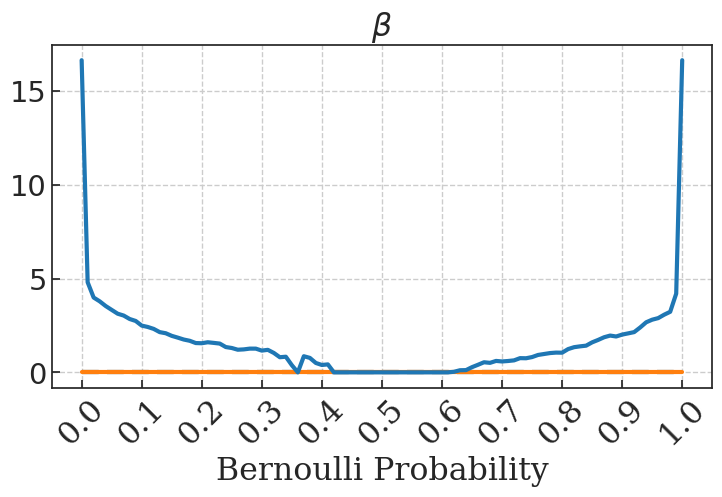

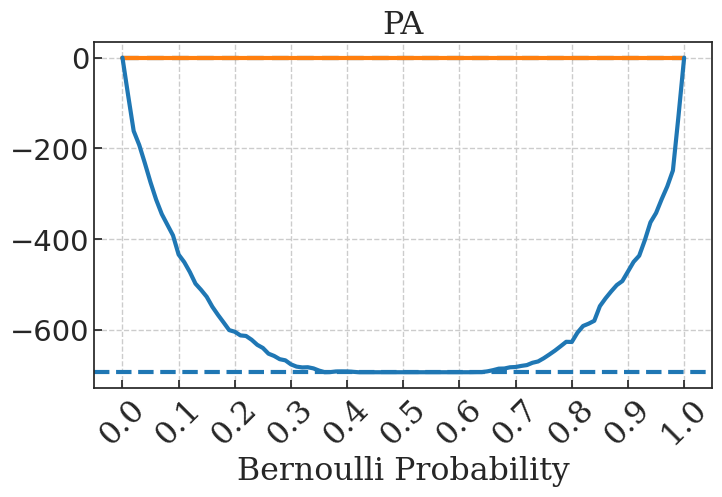

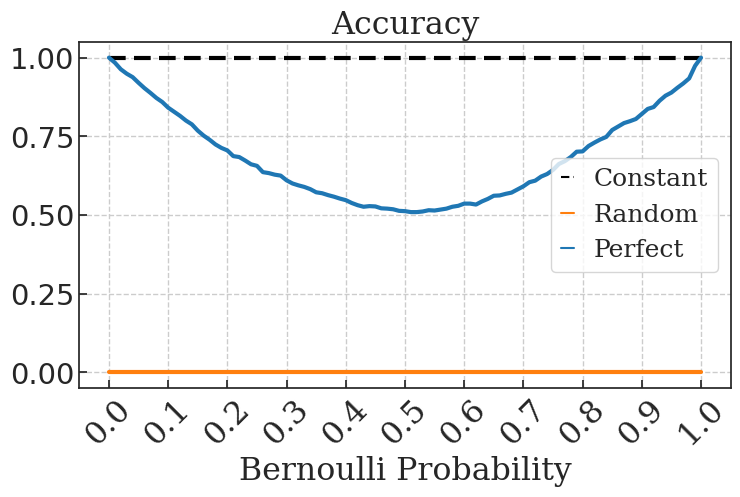

In [37]:
plot_artificial(
    df,
    savedir=r"/cluster/home/vjimenez/adv_pa_new/results/artificial",
    save=False,
    yscale="linear",
    legend=True
)